In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

In [7]:
%autoreload
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', 60)
example.metadata

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


size  spacing  origin  limit  center  extent
variable dimension                                              
wave     x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre      x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01
mre_mask x            80    0.001     0.0  0.079  0.0395    0.08
         y           100    0.001     0.0  0.099  0.0495    0.10
         z            10    0.001     0.0  0.009  0.0045    0.01

In [8]:
example.describe()

dtype    count                     mean          std  \
variable component                                                              
wave     y          complex128  80000.0  -0.00000100-0.00001000j     0.000724   
         x          complex128  80000.0   0.00022200-0.00020700j     0.000742   
         z          complex128  80000.0   0.00092400+0.00005900j     0.012493   
mre      scalar     complex128  80000.0  3382.375000+376.991118j  1590.727619   
mre_mask scalar          int64  80000.0   1.07650000+0.00000000j     0.362143   

                                        min                      25%  \
variable component                                                     
wave     y          -0.00198900-0.00084800j  -0.00031600+0.00029700j   
         x          -0.00271700+0.00009800j  -0.00007000-0.00019200j   
         z          -0.02294100-0.00252200j  -0.00443200-0.00007700j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                        50%                      75%  \
variable component                                                     
wave     y           0.00002900+0.00024900j   0.00031500+0.00007300j   
         x           0.00017900+0.00008700j   0.00053800-0.00078400j   
         z           0.00069400+0.00010000j   0.00689700-0.01260300j   
mre      scalar     3000.000000+376.991118j  3000.000000+376.991118j   
mre_mask scalar      1.00000000+0.00000000j   1.00000000+0.00000000j   

                                         max  
variable component                            
wave     y          0.001772000+0.000765000j  
         x          0.002784000-0.001559000j  
         z          0.022754000+0.005157000j  
mre      scalar     10000.000000+376.991118j  
mre_mask scalar     5.000000000+0.000000000j

Evaluating direct baseline
Evaluating FEM baseline
Solving slice 1/10
Solving slice 2/10
Solving slice 3/10
Solving slice 4/10
Solving slice 5/10
Solving slice 6/10
Solving slice 7/10
Solving slice 8/10
Solving slice 9/10
Solving slice 10/10


<IPython.core.display.Javascript object>


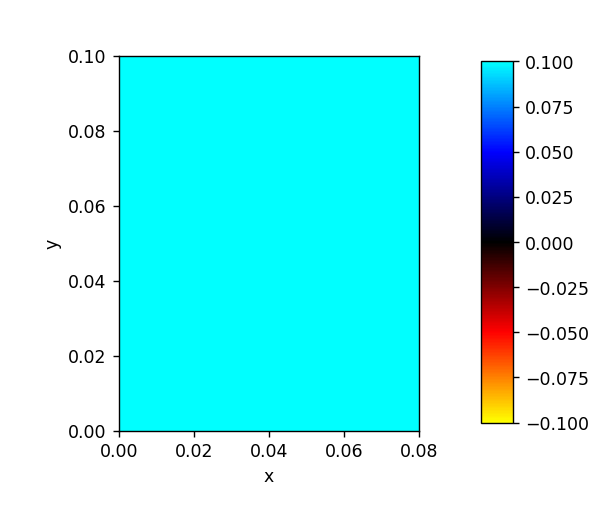

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


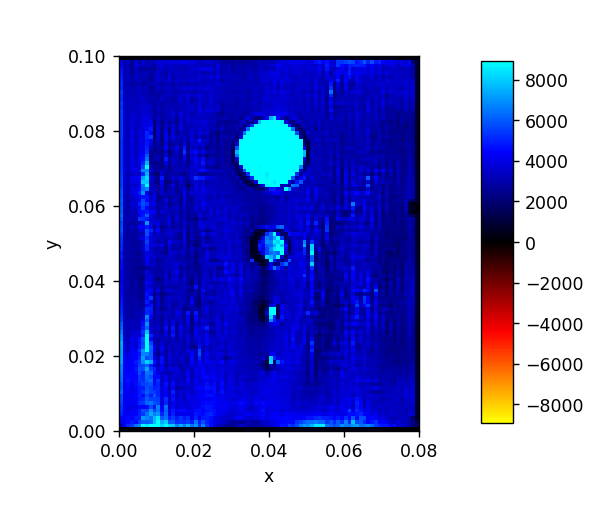

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


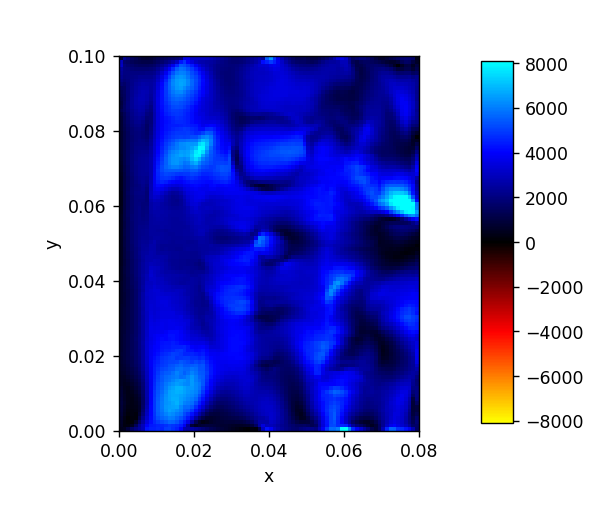

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [6]:
%autoreload
frequency = example.wave.frequency.item()
mre_pinn.baseline.eval_direct_baseline(example, frequency=frequency)
mre_pinn.baseline.eval_fem_baseline(example, frequency=frequency, hete)
example.view('mre', 'direct', 'fem', ax_height=3, polar=True)

In [25]:
example.fem

<xarray.DataArray 'baseline' (x: 80, y: 100, z: 10)>
array([[[ 4.28850391e+02-6.09027905e+02j,
          3.58053953e+02-2.23765177e+02j,
          2.74875316e+02+1.89137889e+02j, ...,
          2.11387646e+03+2.20347519e+03j,
          5.88105538e+03+4.49907987e+03j,
          1.07831295e+04+1.01979009e+04j],
        [ 6.93871500e+02-3.20190428e+02j,
          4.54466170e+02-3.37262850e+01j,
          1.86715532e+02+3.05358316e+02j, ...,
          3.70404457e+03+2.90070678e+03j,
          1.03898551e+04+2.93512321e+03j,
          1.64255094e+04+4.44799401e+03j],
        [ 7.38480441e+02-7.38975836e+01j,
          4.11531227e+02+4.47763512e+01j,
          1.96267531e+01+2.17107955e+02j, ...,
          5.99333964e+03+3.16907445e+03j,
          1.50408375e+04-1.41664001e+03j,
          1.95383689e+04-3.81817261e+03j],
        ...,
        [ 3.37356099e+03-1.49761228e+03j,
...
          1.52012548e+03+1.27187417e+03j],
        ...,
        [ 3.36628934e+02+9.79990147e+01j,
          3.66063275e+02-4.05842459e+01j,
          1.58268412e+02-1.01187862e+02j, ...,
         -1.27527488e+03-3.06913434e+02j,
         -1.36692478e+03-6.43377753e+02j,
         -1.35926931e+03-9.76226576e+02j],
        [ 9.57668741e+01-1.84690687e+01j,
          1.52433922e+02-5.18543138e+01j,
         -1.92346703e+02-1.61108358e+02j, ...,
         -1.67483339e+03-8.06198816e+02j,
         -1.71635531e+03-1.22881720e+03j,
         -1.66725436e+03-1.47708180e+03j],
        [-3.53675185e+02-4.80462280e+02j,
         -1.71073633e+02-3.72036678e+02j,
         -5.80941789e+02-4.46155421e+02j, ...,
         -1.94320965e+03-7.91805145e+02j,
         -2.04323387e+03-1.13691129e+03j,
         -2.03828729e+03-1.25009372e+03j]]])
Coordinates:
    frequency       int64 60
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
  * z               (z) float64 0.0 0.001 0.002 0.003 ... 0.007 0.008 0.009
    spatial_region  (x, y, z) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1

In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', omega=frequency, detach=True)

NameError: name 'frequency' is not defined

In [9]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=5,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=2, bias=True)
  )
)

In [26]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-10,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000385 s



In [27]:
%autoreload
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0004s (0.67%)
Model time/iter: 0.0007s (1.26%)
Loss time/iter:  0.0573s (98.07%)
Total time/iter: 0.0584s
Total time: 5.8427s
1k iters time: 0.97m
10k iters time: 9.74m
100k iters time: 1.62h


<IPython.core.display.Javascript object>


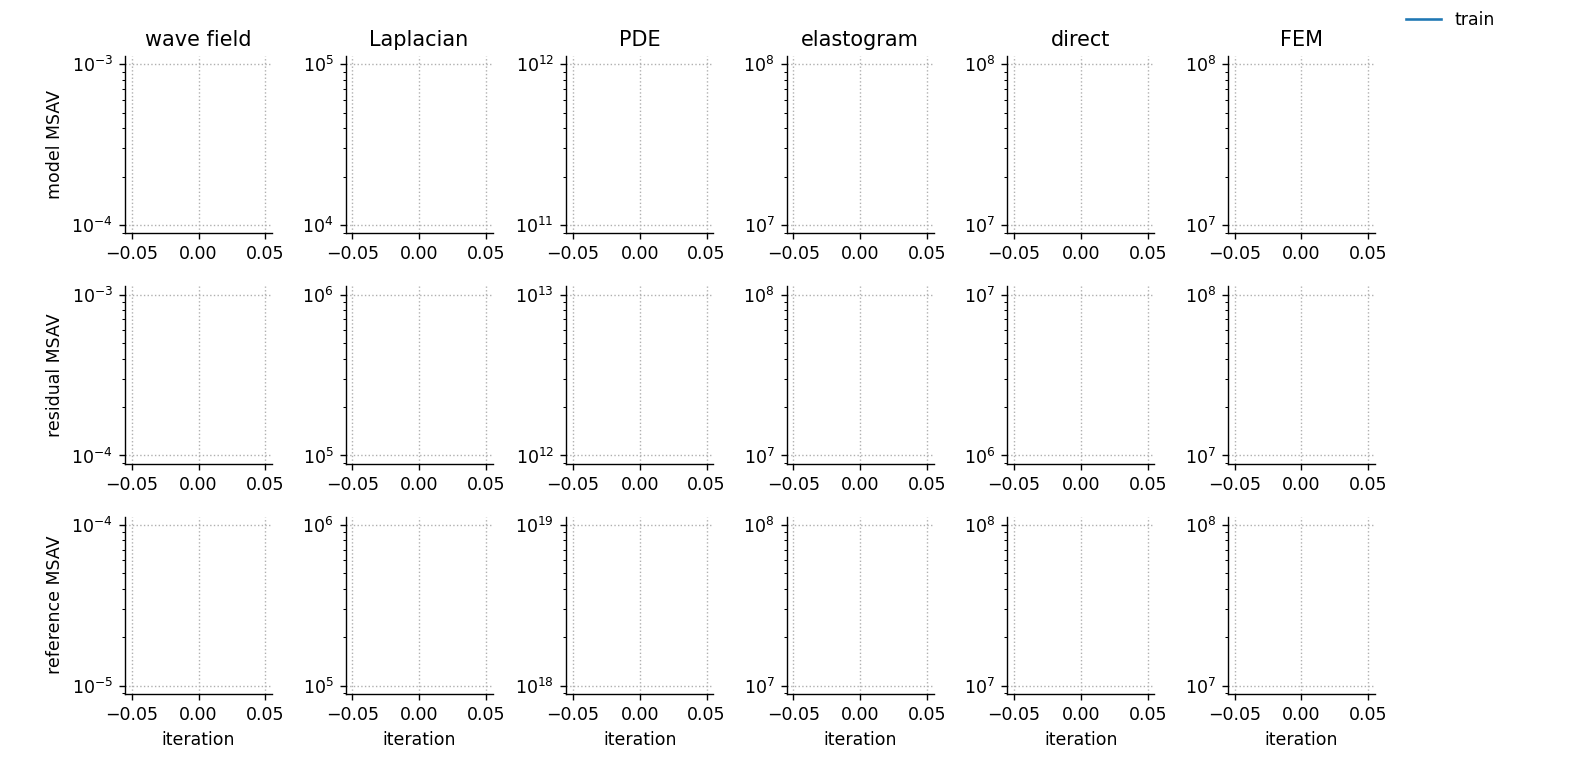

<IPython.core.display.Javascript object>


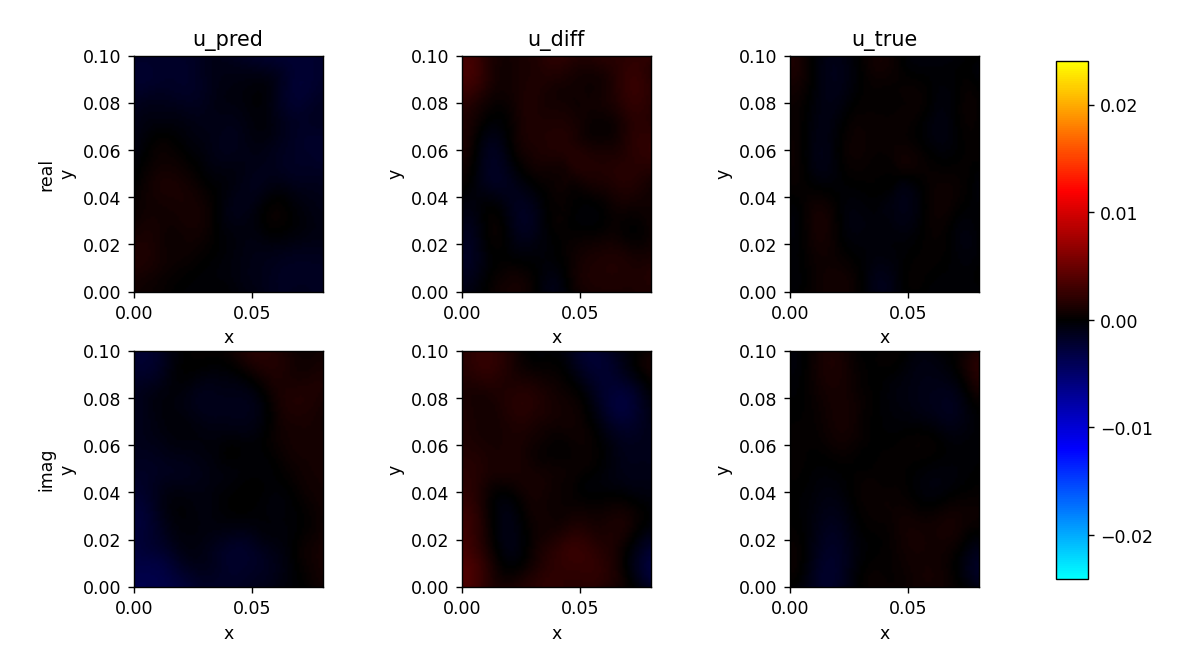

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


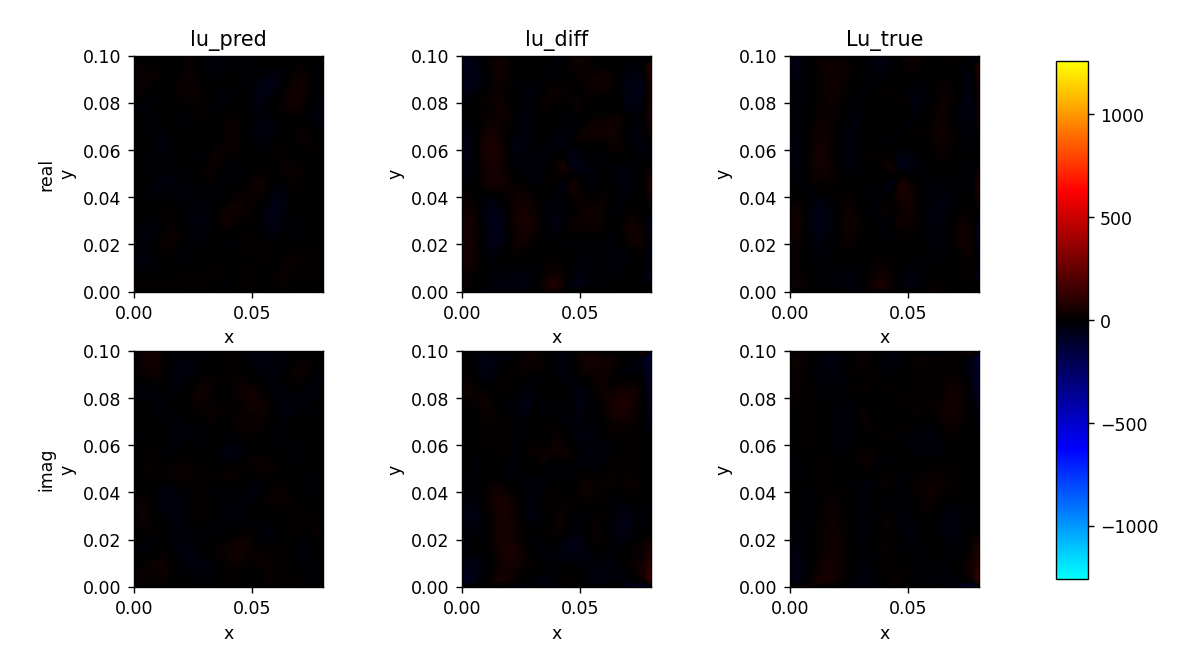

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


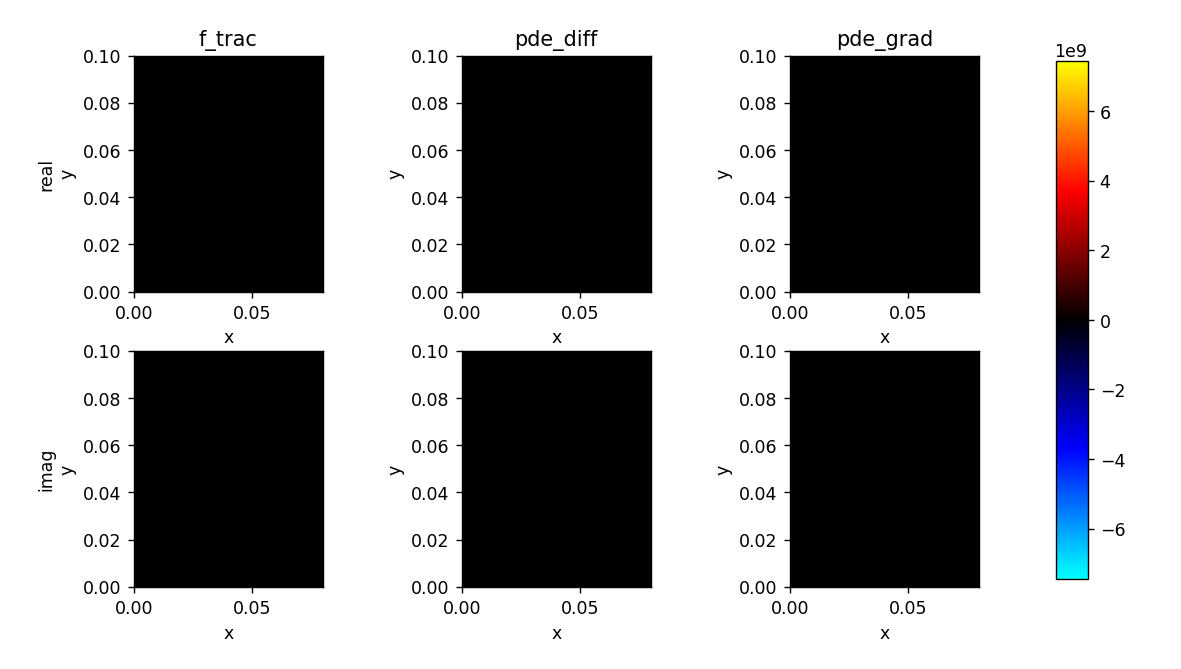

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


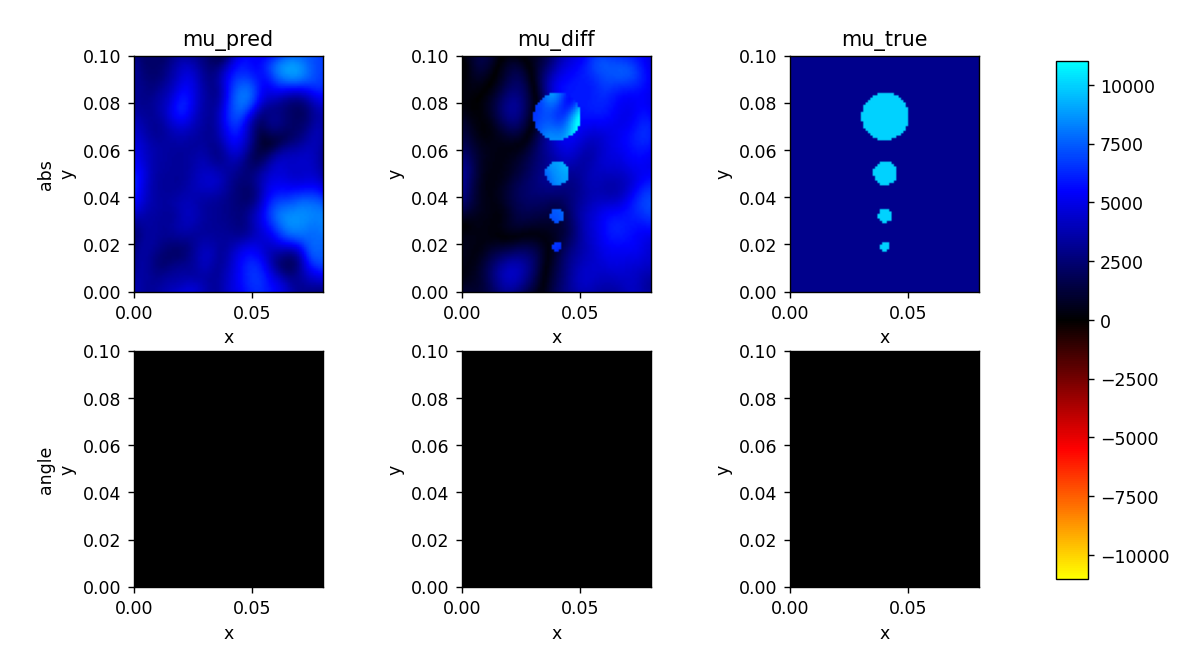

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


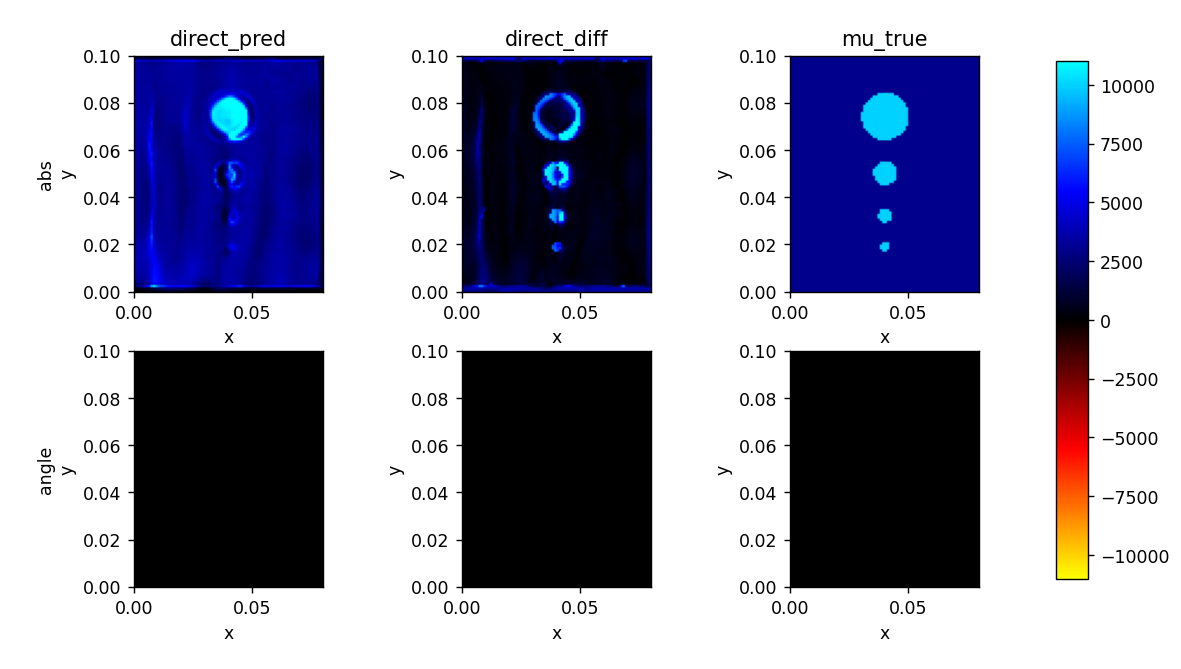

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


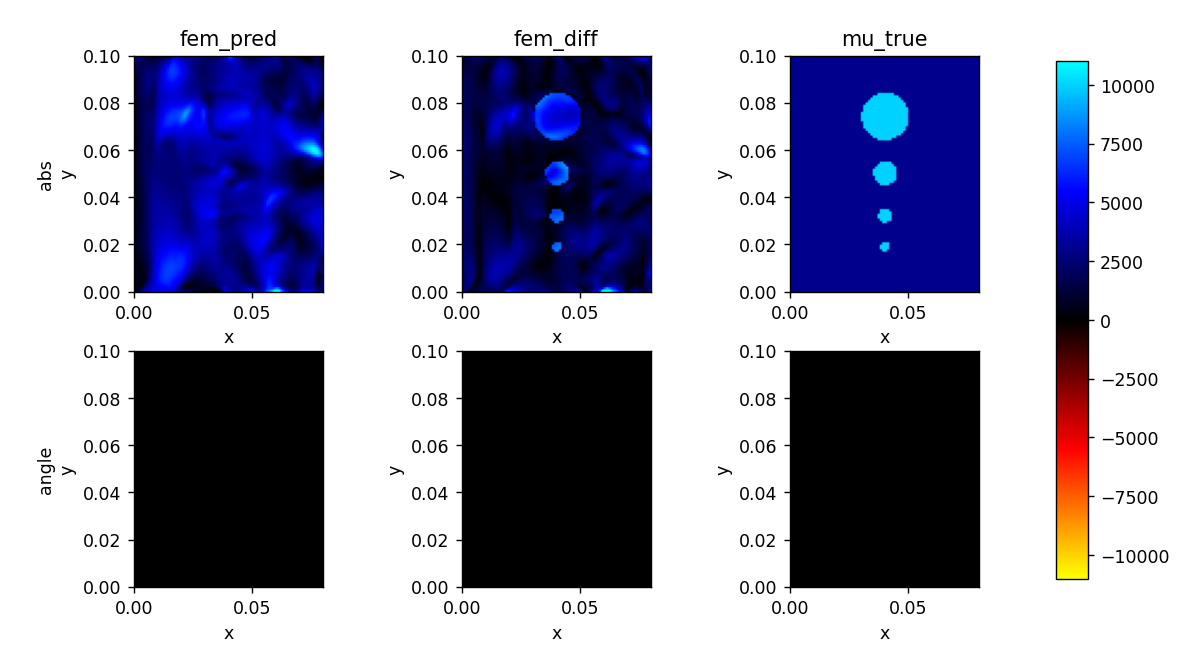

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [35]:
%autoreload
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])